<font size="6"><center><b>Fundamentos de *Deep Learning*</b></center></font>

<font size="4"><center><b>Redes Neurais Recorrentes</b></center></font>
  
<font size="3"><center>Prof. Dr. Renato Moraes Silva</center></font>
<br/>

# <center>LSTM e GRU usando TensorFlow</center>

Neste exercício, usaremos os métodos LSTM (*long short-term memory*) e GRU (*gated recurrent units*) para classificar notícias falsas (*fake news*).

Veja um exemplo de notícia falsa:
 * ```Polos magnéticos da Terra podem se inverter e causar colapso mundial: "A Terra ficaria inabitável". Aos menos 100 mil pessoas morreriam por ano pela alta nos níveis de radiação espacial." Se o campo magnético continuar a diminuir e os polos magnéticos se inverterem, a Terra pode acabar como Marte – um local seco, árido e incapaz de preservar a vida.```
 
Exemplo de notícia verdadeira:
 * ```Inversão dos polos magnéticos da Terra pode ocorrer mais rápido do que o previsto. Segundo afirmações, essas ocorrências são, a princípio, indistinguíveis das verdadeiras mudanças nos polos. Apesar dessas reversões não representarem qualquer ameaça à humanidade, os especialistas alertam que poderão gerar falhas nos satélites que orbitam a Terra.```
 
 
Dentro da pasta `datasets`, há uma base de dados de notícias falsas. Essa base pode ser encontrada no seguinte link: <https://github.com/roneysco/Fake.br-Corpus>. Ela foi publicada no seginte artigo científico: 

- R. A. Monteiro, R. L. S. Santos, T. A. S. Pardo, T. A. de Almeida, E. E. S. Ruiz, O. A. Vale (2018). Contributions to the study of fake news in
portuguese: New corpus and automatic detection results. In 13th International Conference on Computational Processing of the Portuguese Language
(PROPOR’2018) (pp. 324–334). Canela, Rio Grande do Sul, Brazil: Springer
International Publishing. DOI: [10.1007/978-3-319-99722-3_33](http://dx.doi.org/10.1007/978-3-319-99722-3_33).
 
Primeiro, vamos importar as bibliotecas que serão usadas neste exercício.

In [1]:
import numpy as np # biblioteca usada para trabalhar com vetores e matrizes
import pandas as pd # biblioteca usada para trabalhar com dataframes e análise de dados
import re # biblioteca para expressoes regulares
import os # biblioteca usada para realizar tarefas específicas ao SO

from zipfile import ZipFile # biblioteca para arquivos zipados

Vamos importar os dados da base.

In [2]:
def import_fakeNewsDataset(path):

    files = os.listdir(path)
    
    dataset = []

    for i, file in enumerate(files):
        # abre o arquivo
        fileTexto = open(path+'/'+file, "r", encoding='utf8', errors='replace') #utf8 #cp1252
        
        # le o arquivo e armazena o texto dentro da variavel "texto"
        texto = fileTexto.read()

        dataset.append(texto)

    return dataset


# descompacta a base de dados de notícias
z = ZipFile('datasets/Fake.br-Corpus-master.zip', 'r')
z.extractall('datasets/')
z.close()

# importa a base de dados de noticias falsas
dataset_fake = import_fakeNewsDataset('datasets/Fake.br-Corpus-master/full_texts/fake/')
print('Noticias falsas importadas com sucesso')

# cria um vetor de 1 para indicar a classe de cada noticia falsa
target_fake = np.ones( len(dataset_fake), dtype=int )

# importa a base de dados de noticias falsas
dataset_true = import_fakeNewsDataset('datasets/Fake.br-Corpus-master/full_texts/true/')
print('Noticias verdadeiras importadas com sucesso')

# cria um vetor de 0 para indicar a classe de cada noticia verdadeira
target_true = np.zeros( len(dataset_true), dtype=int )

# concatena as noticias verdadeiras e falsas
dataset2 = np.asarray( dataset_fake+dataset_true )

# concatena os vetores de classes das notícias verdadeiras e falsas
target2 = np.concatenate((target_fake,target_true))

# obtem as classes do problema
classes2 = np.unique(target2)

print('\nQtd. de noticias falsas: %d' %len(dataset_fake))
print('Qtd. de noticias verdadeiras: %d' %len(dataset_true))

Noticias falsas importadas com sucesso
Noticias verdadeiras importadas com sucesso

Qtd. de noticias falsas: 3600
Qtd. de noticias verdadeiras: 3600


Agora, vamos tratar os textos importados da base de dados. Como as notícias foram escritas em língua portuguesa, devemos usar uma função de estemização apropriada para a língua portuguesa. Iremos também remover os acentos das palavras. 

Outro ponto importante é que as notícias verdadeiras em geral são mais longas que as notícias falsas. Então, para evitar que a predição do classificador seja mais influenciada pelo tamanho da notícia do que pelo conteúdo, na função de pré-processamento, o texto será truncado para apenas 200 termos.

In [3]:
import unicodedata # sera usada para remover acentos dos documentos em lingua portuguesa

def preprocessing_portuguese(text):
    """
    Funcao usada para tratar textos escritos na lingua portuguesa
    
    Parametros: 
        text: variavel do tipo string que contem o texto que devera ser tratado
        
        stemming: variavel do tipo boolean que indica se a estemizacao deve ser aplicada ou nao
        
        stopwords: variavel do tipo boolean que indica se as stopwords devem ser removidas ou nao
    """
    
    # Lower case
    text = text.lower()
    
    # remove os acentos das palavras
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
    
    # remove tags HTML
    regex = re.compile('<[^<>]+>')
    text = re.sub(regex, " ", text) 
    
    # normaliza as URLs
    regex = re.compile('(http|https)://[^\s]*')
    text = re.sub(regex, "<URL>", text)

    # normaliza emails
    regex = re.compile('[^\s]+@[^\s]+')
    text = re.sub(regex, "<EMAIL>", text)
    
    # converte todos os caracteres não-alfanuméricos em espaço
    regex = re.compile('[^A-Za-z0-9]+') 
    text = re.sub(regex, " ", text)
    
    # normaliza os numeros 
    regex = re.compile('[0-9]+')
    text = re.sub(regex, "<NUMERO>", text)
    
    # substitui varios espaçamentos seguidos em um só
    text = ' '.join(text.split())

    # separa o texto em palavras
    words = text.split() 
        
    # trunca o texto para apenas 200 termos
    words = words[0:200]

    # remove palavras compostas por apenas um caracter
    words = text.split() # separa o texto em palavras
    words = [ w for w in words if len(w)>1 ]
    text = " ".join( words )
    
    return text

exemplo_noticia = 'Polos magnéticos da Terra podem se inverter e causar colapso mundial: "A Terra ficaria inabitável". Aos menos 100 mil pessoas morreriam por ano pela alta nos níveis de radiação espacial." Se o campo magnético continuar a diminuir e os polos magnéticos se inverterem, a Terra pode acabar como Marte – um local seco, árido e incapaz de preservar a vida.'
print('Antes do preprocessamento: \n', exemplo_noticia)

# executa a função de pré-processsamento para tratar a amostra de texto
exemplo_noticia = preprocessing_portuguese(exemplo_noticia)

print('\nDepois do preprocessamento: \n', exemplo_noticia)

Antes do preprocessamento: 
 Polos magnéticos da Terra podem se inverter e causar colapso mundial: "A Terra ficaria inabitável". Aos menos 100 mil pessoas morreriam por ano pela alta nos níveis de radiação espacial." Se o campo magnético continuar a diminuir e os polos magnéticos se inverterem, a Terra pode acabar como Marte – um local seco, árido e incapaz de preservar a vida.

Depois do preprocessamento: 
 polos magneticos da terra podem se inverter causar colapso mundial terra ficaria inabitavel aos menos <NUMERO> mil pessoas morreriam por ano pela alta nos niveis de radiacao espacial se campo magnetico continuar diminuir os polos magneticos se inverterem terra pode acabar como marte um local seco arido incapaz de preservar vida


Agora, vamos dividir os dados em treino e teste de forma estratificada. Usaremos novamente a validação *holdout* estratificada por motivos didáticos. No entanto, sempre que for possível, é mais recomendado usar a validação cruzada K-fold, pois é mais robusta.

In [4]:
import sklearn as skl # sckit-learn
from sklearn import model_selection 

# divide os dados em treino e teste
cv2 = skl.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=2019)

# retorna os índices de treino e teste
train_index2, test_index2 = list( cv2.split(dataset2, target2) )[0]

# retorna as partições de treino e teste de acordo com os índices
dataset2_train, dataset2_test = dataset2[train_index2], dataset2[test_index2];
Y2_train, Y2_test = target2[train_index2], target2[test_index2];

print('Qtd. dados de treinamento: %d (%1.2f%%)' %(dataset2_train.shape[0], (dataset2_train.shape[0]/dataset2.shape[0])*100) )
print('Qtd. de dados de teste: %d (%1.2f%%)' %(dataset2_test.shape[0], (dataset2_test.shape[0]/dataset2.shape[0])*100) )

# imprime a porcentagem de dados de treinamento de cada classe
print("\nQtd. de dados de cada classe (treinamento)")
cTrain, counts_cTrain = np.unique(np.sort(Y2_train), return_counts=True)
for i in range( len(cTrain) ):
    print('\tClasse %s: %d (%1.2f%%)' %( cTrain[i],counts_cTrain[i],(counts_cTrain[i]/len(Y2_train))*100 ) )

# imprime a porcentagem de dados de teste de cada classe
print("\nQtd. de dados de cada classe (teste)")
cTest, counts_cTest = np.unique(np.sort(Y2_test), return_counts=True)
for i in range( len(cTrain) ):
    print('\tClasse %s: %d (%1.2f%%)' %( cTest[i],counts_cTest[i],(counts_cTest[i]/len(Y2_test))*100 ) )

Qtd. dados de treinamento: 5040 (70.00%)
Qtd. de dados de teste: 2160 (30.00%)

Qtd. de dados de cada classe (treinamento)
	Classe 0: 2520 (50.00%)
	Classe 1: 2520 (50.00%)

Qtd. de dados de cada classe (teste)
	Classe 0: 1080 (50.00%)
	Classe 1: 1080 (50.00%)


Aplica o pré-processamento nos dados de treinamento e de teste.

In [5]:
########################## COMPLETE O CÓDIGO AQUI  ########################
    
# aplica o pre-processamento nos dados de treinamento
print('Qtd. de documentos de treinamento tratados: ')
for i, msg in enumerate(dataset2_train):  
    dataset2_train[i] = preprocessing_portuguese(dataset2_train[i])
    
    if i%50==0 or i==len(dataset2_train)-1:
        print(' %d de %d' %(i+1, len(dataset2_train)), end='\r')
    
print('\n\nPrimeira mensagem de treinamento apos o pre-processamento:')
print('\n%s\n%s\n%s\n' %(50*'-',dataset2_train[10],50*'-'))

# aplica o pre-processamento nos dados de teste
print('Qtd. de documentos de teste tratados: ')
for i, msg in enumerate(dataset2_test):
    dataset2_test[i] = preprocessing_portuguese(dataset2_test[i])
    
    if i%50==0 or i==len(dataset2_test)-1:
        print(' %d de %d' %(i+1, len(dataset2_test)), end='\r')
    
print('\n\nPrimeira mensagem de teste apos o pre-processamento:')

print('\n%s\n%s\n%s\n' %(50*'-',dataset2_test[10],50*'-'))

##########################################################################

Qtd. de documentos de treinamento tratados: 
 5040 de 5040

Primeira mensagem de treinamento apos o pre-processamento:

--------------------------------------------------
homem faz apelo pela internet minha esposa doou todo meu dinheiro para igreja me ajudem por favor empresario conta que tem lutado muito pra juntar um dinheirinho com objetivo de dar uma condicao melhor para sua familia peco aos meus amigos que publiquem esse video estou indignado minha mulher pegou um dinheiro altissimo em nosso quarto doou tudo para universal reginaldo conta que um homem honesto quem me conhece sabe quanto eu sou trabalhador eu acordo as <NUMERO> horas da manha para trabalhar tenho uma empresa de materiais de construcao aparentemente desesperado ele relata que ainda tentou conversar com pastor para tentar ressarcir prejuizo mas foi em vao confira
--------------------------------------------------

Qtd. de documentos de teste tratados: 
 2160 de 2160

Primeira mensagem de teste apos o pre-processament

---
## Gerando word embeddings

Depois de fazer o pré-processamento, é necessário transformar o texto em um vetor de atributos com valores numéricos. Podemos fazer isso usando word embeddings pré-treinadas ou treinando um modelo próprio. 

Neste momento, vamos treinar modelo próprio de embeddings baseado nos dados de treinamento. Para manipular as embeddings, iremos usar a biblioteca Gensim: https://radimrehurek.com/gensim/models/word2vec.html

Primeiro, é necessário transformar cada mensagem de texto da base de dados em uma lista de palavras. 

In [6]:
########################## COMPLETE O CÓDIGO AQUI  ########################

newDatasetTrain = []
for msg in dataset2_train:
    newDatasetTrain.append( msg.split() )

print("Primeira mensagem de texto: ")    
print( newDatasetTrain[0] )

##########################################################################

Primeira mensagem de texto: 
['depois', 'da', 'condenacao', 'do', 'ex', 'senador', 'gim', 'argello', 'ja', 'da', 'pra', 'imaginar', 'que', 'ira', 'acontecer', 'com', 'lula', 'juiz', 'federal', 'sergio', 'moro', 'condenou', 'ontem', '<NUMERO>', 'ex', 'senador', 'gim', 'argello', 'ex', 'ptb', 'df', '<NUMERO>', 'anos', 'de', 'prisao', 'argello', 'foi', 'condenado', 'pelos', 'crimes', 'de', 'corrupcao', 'passiva', 'lavagem', 'de', 'dinheiro', 'obstrucao', 'investigacao', 'de', 'organizacao', 'criminosa', 'ele', 'podera', 'recorrer', 'da', 'decisao', 'de', 'moro', 'porem', 'permanecera', 'preso', 'magistrado', 'tambem', 'determinou', 'confisco', 'de', '<NUMERO>', '<NUMERO>', 'milhoes', 'argumentou', 'que', 'valor', 'deve', 'ser', 'considerado', 'para', 'reparacao', 'da', 'atuacao', 'criminosa', 'do', 'ex', 'parlamentar', 'abaixo', 'parte', 'da', 'sentenca', 'de', 'moro', 'condenado', 'ao', 'inves', 'de', 'cumprir', 'com', 'seu', 'dever', 'aproveitou', 'poder', 'oportunidade', 'para', 'enriq

Agora, vamos treinar o modelo de embeddings.

In [7]:
########################## COMPLETE O CÓDIGO AQUI  ########################

import gensim
from gensim.models import Word2Vec

embeddingModel = Word2Vec(sentences=newDatasetTrain, vector_size=200, window=3, min_count=1, workers=4)

# vamos extrair as palavras do modelo
vocabSize = len(embeddingModel.wv)
print("Tamanho do vocabulário do modelo: ", vocabSize)

##########################################################################

Tamanho do vocabulário do modelo:  70043


Para extrair o vetor de uma determinada palavra, podemos usar o código apresentado abaixo.

In [8]:
########################## COMPLETE O CÓDIGO AQUI  ########################

vector = embeddingModel.wv['politica']  # get numpy vector of a word
print(vector)

##########################################################################

[-0.13780183 -0.47851437 -0.49100792 -0.7036973   0.29102388  0.3785438
 -0.4803222   0.8242286   1.0800672   0.05669897 -0.14903243  0.3255026
 -0.48523352 -0.92283    -2.140858   -1.640292    0.991216    0.23255888
  1.2622147  -0.96160746  0.3456739  -1.1333035  -0.45280212  0.07687458
  0.61585796 -0.84507066 -0.1975738  -0.6979224  -0.41053063 -0.59127396
  0.67632115  1.163868   -0.1487753  -0.2784731   0.99239     0.40587145
  0.18719035 -0.3762586  -0.27118328 -0.53415114  0.37862396 -0.4278995
 -0.03914588 -0.312525    0.1772224   1.2523248  -0.3801391  -0.43492723
 -0.7160114  -0.5820115   0.85433054 -0.40051     0.05550257  0.3372961
 -0.9247904   0.40673187 -1.1745541   0.12484369 -0.6751507   0.4536457
  0.09853959  0.9982116  -0.6596215   0.30871755 -0.6924605   1.0648406
 -0.99054545  0.00428999  0.15766111  1.6206405   0.18888628  0.74701774
  0.14004028  0.598248    0.129863    0.11150134  0.01208877 -1.3803105
  0.09644058  0.64966655  0.0448433   0.79023767 -0.815464

O código abaixo apresenta os termos mais próximas de uma determinada termos com base similaridade de coseno.  

In [9]:
sims = embeddingModel.wv.most_similar('mulher', topn=10)  # get other similar words
for sim in sims:
    print(sim)

('mae', 0.8287518620491028)
('filha', 0.8232411742210388)
('esposa', 0.765908420085907)
('menina', 0.756527841091156)
('vitima', 0.7509697675704956)
('crianca', 0.7320523858070374)
('namorada', 0.7164527773857117)
('amiga', 0.7142543196678162)
('irma', 0.712066113948822)
('jovem', 0.7084388136863708)


---
## Gerando vetores para os documentos 

Nós treinamos um modelo que encontra um vetor de representação para cada palavra do vocabulário. No entanto, nós queremos também gerar um vetor para o documento. 

Para a LSTM devemos apresentar o documento como um conjunto de vetores de palavras em sequência.

Outro ponto importante é que devemos estabelecer uma tamanho máximo de palavras por documento. Se um determinado documento possui mais palavras do que o tamanho máximo, devemos fazer o processo de **truncamento**: eliminar as últimas palavras do documento. Caso o documento possua menos palavras que o limite máximo, devemos fazer o processo de **padding**: preencher os vetores das palavras que faltam para completar o tamanho máximo com valores 0. Por fim, iremos representar as palavras que não forem encontradas no modelo de *embeddings* com um vetor de zeros também.

In [10]:
def getDocvector(model, doc, maxLength = 200): 
    """
    Obtem o vetor de cada palavra de um documento e calcula um vetor medio
    """
    
    ########################## COMPLETE O CÓDIGO AQUI  ########################
    
    # obtem a dimensao dos vetores das palavras do modelo
    embedding_dim = model.wv[model.wv.index_to_key[0]].shape[0]
    
    # iniciliza a lista de vetores das palavras do documento   
    wordVecs = []
    
    for i in range(maxLength):
        
        # inicializa o vetor da palavra com um vetor de zeros
        # caso essa palavra exista, o vetor será trocado posteriormente pela embedding do modelo
        wordVecs.append( np.zeros(embedding_dim) )
        
        if i<len(doc):
            
            try:
                wordVecs[i] = model.wv[ doc[i] ] 
            except:
                pass # essa termo do python significa que não há nada a fazer
            

    wordVecs = np.array(wordVecs)
    ##########################################################################

    return wordVecs

# vamos testar em uma frase
doc = ['i', 'have', 'a', 'date', 'on', 'sunday']

# limite do truncamento usado no padding (quantas palavras tera na representacao de cada texto)
maxLength = 200

docVector = getDocvector(embeddingModel, doc, maxLength = maxLength)
print("Dimensao do vetor do documento: ", docVector.shape)

Dimensao do vetor do documento:  (200, 200)


---
## Treinando o classificador

Como já possuímos um modelo de embeddings treinado, podemos usá-lo para gerar os vetores dos dados de treinamento e de teste.

In [11]:
#obtem os vetores para os dados de treinamento
X_train = []
for doc in dataset2_train:
    X_train.append( getDocvector(embeddingModel, doc.split(), maxLength = maxLength) )

#obtem os vetores para os dados de treinamento
X_test = []
for doc in dataset2_test:
    X_test.append( getDocvector(embeddingModel, doc.split(), maxLength = maxLength) )

# converte a lista de vetores em uma matriz
X_train = np.array(X_train)
X_test = np.array(X_test)

print("Dimensao de X_train: ", X_train.shape)
print("Dimensao de X_test: ", X_test.shape)

Dimensao de X_train:  (5040, 200, 200)
Dimensao de X_test:  (2160, 200, 200)


Como os dados de treinamento e teste já estão vetorizados, podemos usá-los para treinar e testar qualquer método de classificação. Vamos aplicar a rede LSTM. 

Porém, antes disso, vamos verificar se as classes estão no formato binário pois a biblioteca *tensorflow* exige que elas estejam neste formato. Caso não estejam, precisaremos convertê-las.

In [12]:
classes = np.unique(Y2_train)

print("Classes: ", classes)

Classes:  [0 1]


Como verificamos que as classes já estão no formato binário, podemos prosseguir. O código abaixo configura a rede neural LSTM. Como o problema de classificação é binário, podemos configurar a última camada da rede com 1 saída (units=1). Além disso, devemos usar **binary_crossentropy** para o parâmetro **loss**. Se fosse um problema de mais de duas classes, o valor para esse parâmetro deveria ser **categorical_crossentropy**. 

In [13]:
########################## COMPLETE O CÓDIGO AQUI  ########################

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
Iremos setar o parâmetro return_sequences como False, pois estamos interessados 
apenas na última saída da sequência, que representa a previsão para a sequência 
de entrada completa.
  
Se usarmos return_sequences = True, a camada LSTM retornará uma saída para cada 
etapa de tempo da sequência de entrada. Isso pode ser útil em problemas como o 
de sequência para sequência, onde a entrada e a saída têm o mesmo tamanho, e 
estamos interessados em cada saída em cada etapa de tempo.  
"""

embedding_dim = embeddingModel.wv[embeddingModel.wv.index_to_key[0]].shape[0]

model = tf.keras.Sequential()
model.add(layers.LSTM(units=embedding_dim, return_sequences=False, input_shape=(maxLength, embedding_dim)))

# como o problema de classificacao é binario, podemos setar o parametro units=1
model.add(layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("LSTM configurada com sucesso")

##########################################################################


2023-05-02 00:18:27.003786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 00:18:27.012672: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


LSTM configurada com sucesso


Agora, vamos treinar a rede LSTM com os dados. Para ser rápido, iremos usar apenas 5 épocas, mas você pode configurar esse parâmetro para outros valores.

In [14]:
########################## COMPLETE O CÓDIGO AQUI  ########################

# treina o modelo
nEpochs = 5
history = model.fit(X_train, Y2_train, epochs=nEpochs, verbose=1)

# summarize the model
print(model.summary())

##########################################################################

Epoch 1/5
158/158 [==============================] - 135s 821ms/step - loss: 0.3993 - accuracy: 0.8437
Epoch 2/5
158/158 [==============================] - 102s 645ms/step - loss: 0.3246 - accuracy: 0.8597
Epoch 3/5
158/158 [==============================] - 108s 685ms/step - loss: 0.3325 - accuracy: 0.8661
Epoch 4/5
158/158 [==============================] - 110s 698ms/step - loss: 0.2864 - accuracy: 0.8760
Epoch 5/5
158/158 [==============================] - 93s 587ms/step - loss: 0.2645 - accuracy: 0.8835
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 321,001
Trainable params: 321,001
Non-trainable params: 

Vamos plotar a evolução do erro. 

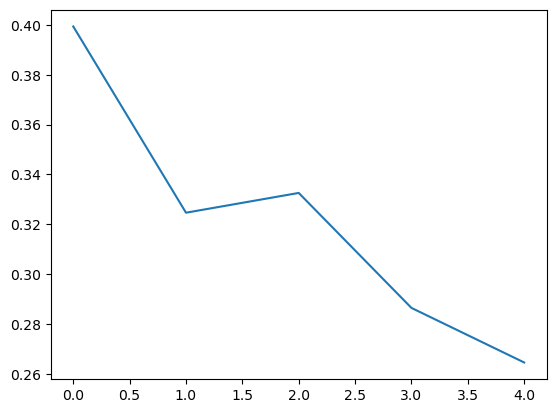

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history['loss'])

plt.plot(hist)
plt.show()

Vamos usar a rede treinada para classificar os dados de teste.

In [16]:
########################## COMPLETE O CÓDIGO AQUI  ########################

def predicao(X_test, Y_test):
    
    # obtem as classes preditas pelo modelo
    y_pred = model.predict(X_test)

    # converte para 1 ou 0
    y_pred[y_pred>=0.5]=1
    y_pred[y_pred<0.5]=0
    y_pred = y_pred.astype(int)
    
    # obtem as medidas de desempenho
    desempenho = skl.metrics.classification_report(Y_test, y_pred)
    
    return y_pred, desempenho

##########################################################################

y_pred, desempenho = predicao(X_test, Y2_test)

print(desempenho)

68/68 [==============================] - 14s 190ms/step
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1080
           1       0.85      0.88      0.86      1080

    accuracy                           0.86      2160
   macro avg       0.86      0.86      0.86      2160
weighted avg       0.86      0.86      0.86      2160



---
## Treinando uma LSTM bidirecional

Repita o código feito anteriormente acrescentando uma camada bidirecional. 

In [17]:
########################## COMPLETE O CÓDIGO AQUI  ########################

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

embedding_dim = embeddingModel.wv[embeddingModel.wv.index_to_key[0]].shape[0]

model = tf.keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(units=embedding_dim, return_sequences=False, input_shape=(maxLength, embedding_dim))))

# como o problema de classificacao é binario, podemos setar o parametro units=1
model.add(layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("LSTM configurada com sucesso")

##########################################################################

LSTM configurada com sucesso


Agora, vamos treinar a rede LSTM com os dados. Para ser rápido, iremos usar apenas 5 épocas, mas você pode configurar esse parâmetro para outros valores.

In [18]:
########################## COMPLETE O CÓDIGO AQUI  ########################
# treina o modelo
nEpochs = 5
history = model.fit(X_train, Y2_train, epochs=nEpochs, verbose=1)

# summarize the model
print(model.summary())
##########################################################################

Epoch 1/5
158/158 [==============================] - 235s 1s/step - loss: 0.3352 - accuracy: 0.8579
Epoch 2/5
158/158 [==============================] - 210s 1s/step - loss: 0.2323 - accuracy: 0.9042
Epoch 3/5
158/158 [==============================] - 214s 1s/step - loss: 0.1926 - accuracy: 0.9190
Epoch 4/5
158/158 [==============================] - 203s 1s/step - loss: 0.1512 - accuracy: 0.9411
Epoch 5/5
158/158 [==============================] - 186s 1s/step - loss: 0.1159 - accuracy: 0.9563
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 400)              641600    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 401       
                                                                 
Total params: 64

Vamos plotar a evolução do erro. 

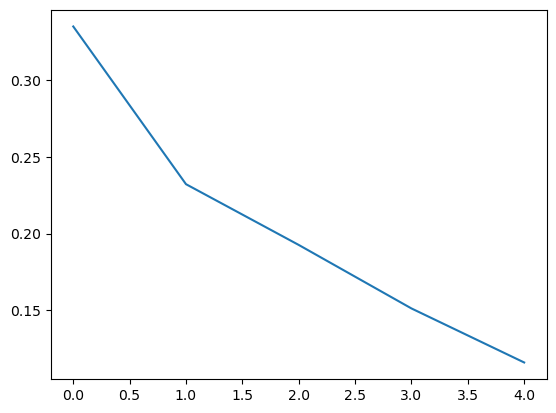

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

########################## COMPLETE O CÓDIGO AQUI  ########################

hist = pd.DataFrame(history.history['loss'])

plt.plot(hist)
plt.show()

##########################################################################

Vamos usar a rede treinada para classificar os dados de teste.

In [20]:
# usa a função que criamos anteriormente para retornar o desempenho
y_pred, desempenho = predicao(X_test, Y2_test)

print(desempenho)

68/68 [==============================] - 36s 492ms/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1080
           1       0.91      0.91      0.91      1080

    accuracy                           0.91      2160
   macro avg       0.91      0.91      0.91      2160
weighted avg       0.91      0.91      0.91      2160



---
## Treinando uma GRU

In [13]:
########################## COMPLETE O CÓDIGO AQUI  ########################

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

embedding_dim = embeddingModel.wv[embeddingModel.wv.index_to_key[0]].shape[0]

model = tf.keras.Sequential()
model.add(layers.GRU(units=embedding_dim, return_sequences=False, input_shape=(maxLength, embedding_dim)))

# como o problema de classificacao é binario, podemos setar o parametro units=1
model.add(layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("GRU configurada com sucesso")

##########################################################################


2023-05-02 01:00:43.491434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 01:00:43.509910: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


GRU configurada com sucesso


Agora, vamos treinar a rede LSTM com os dados. Para ser rápido, iremos usar apenas 5 épocas, mas você pode configurar esse parâmetro para outros valores.

In [14]:
########################## COMPLETE O CÓDIGO AQUI  ########################

# treina o modelo
nEpochs = 5
history = model.fit(X_train, Y2_train, epochs=nEpochs, verbose=1)

# summarize the model
print(model.summary())

##########################################################################

Epoch 1/5
158/158 [==============================] - 109s 644ms/step - loss: 0.4077 - accuracy: 0.8490
Epoch 2/5
158/158 [==============================] - 122s 771ms/step - loss: 0.3396 - accuracy: 0.8607
Epoch 3/5
158/158 [==============================] - 105s 663ms/step - loss: 0.3097 - accuracy: 0.8692
Epoch 4/5
158/158 [==============================] - 92s 581ms/step - loss: 0.2545 - accuracy: 0.8907
Epoch 5/5
158/158 [==============================] - 87s 549ms/step - loss: 0.2162 - accuracy: 0.9139
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200)               241200    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 241,401
Trainable params: 241,401
Non-trainable params: 0

Vamos plotar a evolução do erro. 

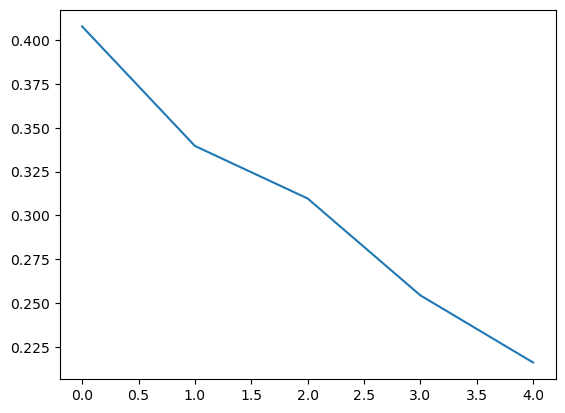

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history['loss'])

plt.plot(hist)
plt.show()

Vamos usar a rede treinada para classificar os dados de teste

In [19]:
y_pred, desempenho = predicao(X_test, Y2_test)

print(desempenho)

68/68 [==============================] - 14s 211ms/step
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1080
           1       0.90      0.88      0.89      1080

    accuracy                           0.89      2160
   macro avg       0.89      0.89      0.89      2160
weighted avg       0.89      0.89      0.89      2160

